# Dashboard de Vendas

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

In [ ]:
# Conexão com PostgreSQL
usuario = 'postgres'
senha = '1234'
host = 'db-devops'
porta = '5432'
banco = 'dashboard'

engine = create_engine(f'postgresql+psycopg2://{usuario}:{senha}@{host}:{porta}/{banco}')

In [5]:
# Leitura de volta das tabelas
df_lojas = pd.read_sql('SELECT * FROM lojas', engine)
df_produtos = pd.read_sql('SELECT * FROM produtos', engine)
df_clima = pd.read_sql('SELECT * FROM clima', engine)
df_chocolate = pd.read_sql('SELECT * FROM chocolate', engine)
df_vendas = pd.read_sql('SELECT * FROM vendas', engine)

#print(df_lojas.head())
print(df_produtos.head())
#print(df_clima.head())
#print(df_chocolate.head())
print(df_vendas.head())

  Cod. Produto                     Produto            Categoria  \
0       BA0001      Barra ao Leite Suprema  Barras de Chocolate   
1       BA0002  Barra com Frutas Vermelhas  Barras de Chocolate   
2       BA0003         Barra Dark Fantasia  Barras de Chocolate   
3       BA0004   Barra de Caramelo Salgado  Barras de Chocolate   
4       BO0001  Bombom de Caramelo Salgado              Bombons   

   Valor Unitario  
0        R$ 21.71  
1        R$ 11.62  
2       R$ 33.76   
3       R$ 41.78   
4       R$ 14.74   
   ID do pedido   Data Cod. Produto ID Loja  Quantidade Valor Unitario  \
0         14242  44197       TR0002  L90011           5           5,37   
1         32104  44197       BA0001  L90011           1          50,42   
2         36203  44197       GO0003  L90011           2          56,29   
3         45805  44197       BO0002  L90011           1          16,42   
4         54884  44197       TR0001  L90011           1           8,06   

  Valor Total  
0       26,85  


# Total de Vendas por Loja

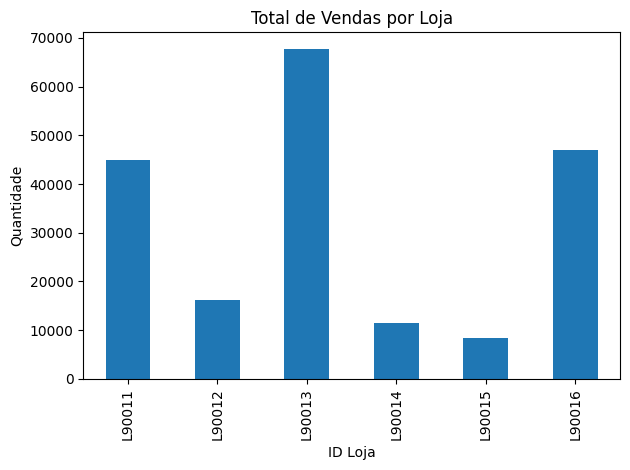

In [6]:
# Agrupamento e visualização
vendas_por_loja = df_vendas.groupby('ID Loja')['Quantidade'].sum()

vendas_por_loja.plot(kind='bar', title='Total de Vendas por Loja', ylabel='Quantidade')
plt.tight_layout()
plt.show()

# Tipos de chocolate × Custo estimado por kg

In [7]:
print(df_chocolate.columns)


Index(['Codigo', 'Tipo de Chocolate', 'Tendencia Atual',
       'Custo Estimado (R$/kg)'],
      dtype='object')


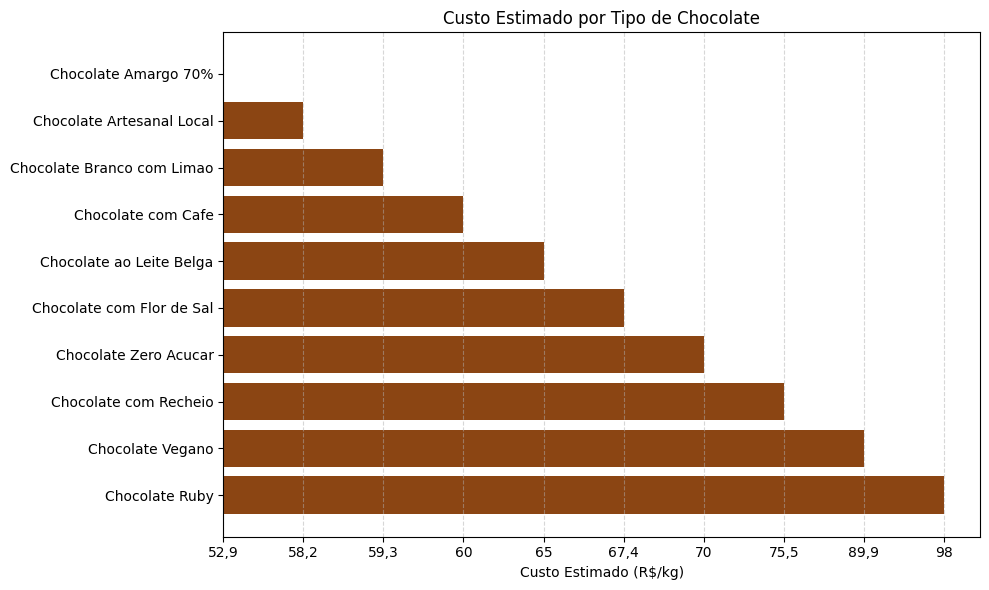

In [8]:
df_chocolate = pd.DataFrame(df_chocolate)

# Ordenar por custo crescente
df_chocolate = df_chocolate.sort_values(by='Custo Estimado (R$/kg)', ascending=True)

# Plotar gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(df_chocolate['Tipo de Chocolate'], df_chocolate['Custo Estimado (R$/kg)'], color='saddlebrown')
plt.xlabel('Custo Estimado (R$/kg)')
plt.title('Custo Estimado por Tipo de Chocolate')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.gca().invert_yaxis()  # Mais caro no topo
plt.show()

# Gráfico de bolhas ou wordcloud: Tendências atuais, visualizando os temas mais frequentes nas descrições (ex: “fitness”, “gourmet”, “sofisticado”).

### Participação de Cada categoria no total de vendas

In [7]:
df_merge = df_vendas.merge(df_produtos, on='Cod. Produto')
df_merge['Valor Total'] = df_merge['Valor Total'].replace(',', '.', regex=True).astype(float)

tabela = df_merge.groupby(['Categoria'])['Valor Total'].sum().reset_index()

label = df_merge['Categoria']
valores = df_merge['Valor Total']

# Gráfico
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(valores, labels=label, autopct='%1.1f%%', startangle=90, wedgeprops={'width':0.4})

# Estilo
ax.axis('equal')  # Deixa o círculo redondo
plt.title('Participação de Vendas por Categoria')
plt.show()

KeyboardInterrupt: 

### Gráico de Barras Agrupadas: Total de vendas por loja X Categoria

ID do pedido       0
Data               0
Cod. Produto       0
ID Loja            0
Quantidade         0
Valor Unitario     0
Valor Total        0
Loja               0
Cidade             0
Produto            0
Categoria          0
 Valor Unitario    0
dtype: int64
object


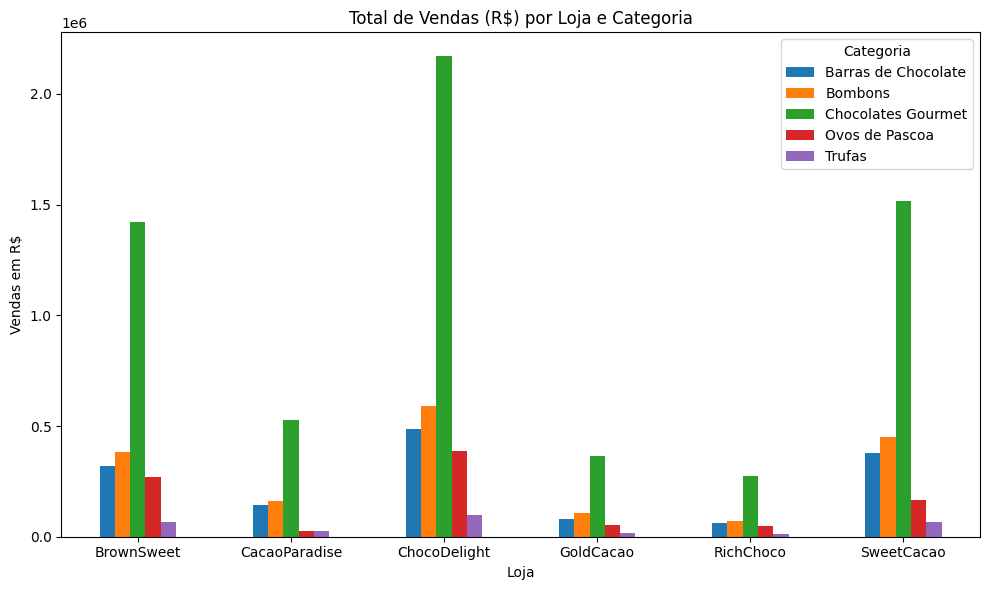

In [27]:
# Juntando os dados de Vendas, Produtos, e Lojas
df = df_vendas.merge(df_lojas, on='ID Loja')

# Juntar com lojas (para pegar nome da loja)
df = df.merge(df_produtos, on='Cod. Produto')

# Mudando o tipo do valor total para Float
df['Valor Total'] = df['Valor Total'].replace(',', '.', regex=True).astype(float)

# Agrupando por loja 
tabela = df.groupby(['Loja', 'Categoria'])['Valor Total'].sum().reset_index()

# Pivotar para gráfico de barras agrupadas
pivotada = tabela.pivot(index='Loja', columns='Categoria', values='Valor Total').fillna(0)

# Plotar
pivotada.plot(kind='bar', figsize=(10, 6))
plt.title('Total de Vendas (R$) por Loja e Categoria')
plt.ylabel('Vendas em R$')
plt.xlabel('Loja')
plt.xticks(rotation=0)
plt.legend(title='Categoria')
plt.tight_layout()
plt.show()

### HeatMap - Relação entre loja e produto mais vendido

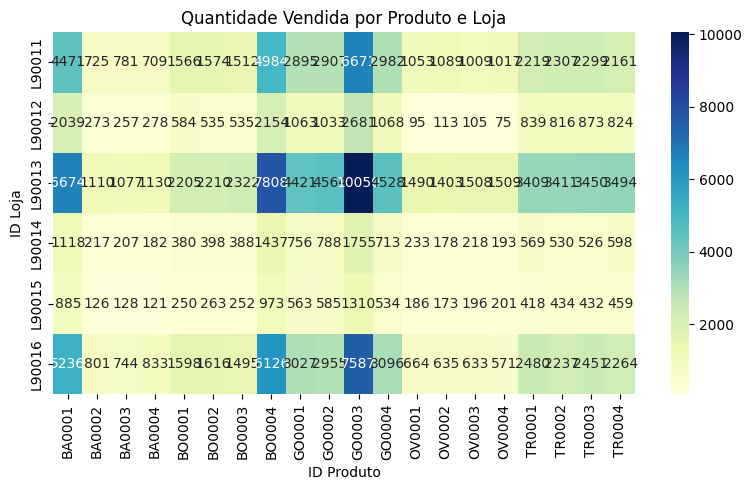

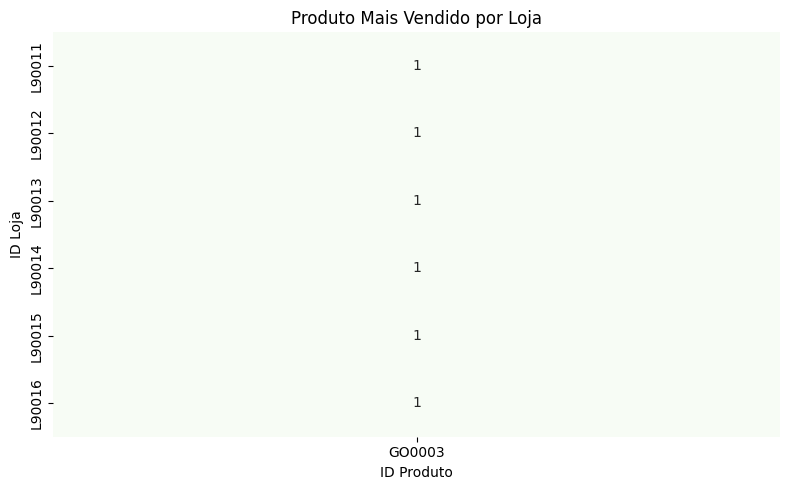

In [14]:
tabela = df_vendas.pivot_table(index='ID Loja', columns='Cod. Produto', values='Quantidade', aggfunc='sum', fill_value=0)

# Criar heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(tabela, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Quantidade Vendida por Produto e Loja')
plt.xlabel('ID Produto')
plt.ylabel('ID Loja')
plt.tight_layout()
plt.show()

# Heatmap de produto mais vendido
grupo = df_vendas.groupby(['ID Loja', 'Cod. Produto'])['Quantidade'].sum().reset_index()
produto_mais_vendido = grupo.sort_values(['ID Loja', 'Quantidade'], ascending=[True, False]).drop_duplicates('ID Loja')

# Criando coluna axuliar (que funcionará como uma medida)
produto_mais_vendido['mais_vendido'] = 1

# Pivotar para formar a matriz loja x produto
heatmap_data = produto_mais_vendido.pivot(index='ID Loja', columns='Cod. Produto', values='mais_vendido').fillna(0)

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, cmap='Greens', cbar=False)
plt.title('Produto Mais Vendido por Loja')
plt.xlabel('ID Produto')
plt.ylabel('ID Loja')
plt.tight_layout()
plt.show()



### Quantidade de cidades por clima predominante

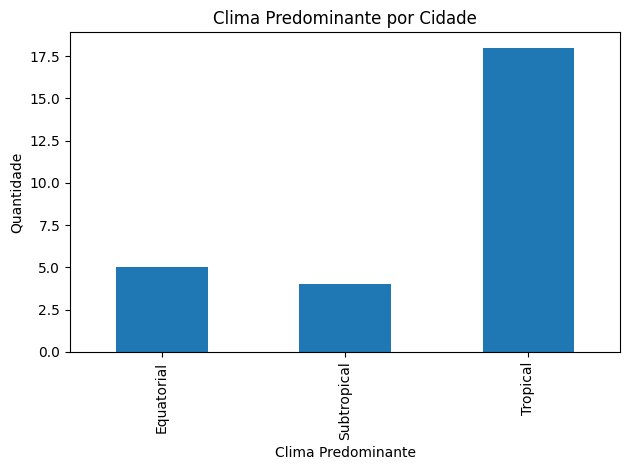

In [11]:
cidades_clima = df_clima.groupby('Clima Predominante')['Cidade'].count()

cidades_clima.plot(kind='bar', title='Clima Predominante por Cidade', ylabel='Quantidade')
plt.tight_layout()
plt.show()

### Gráfico de mapa: Localização da Loja X Clima